#In this problem we aim to implement PCA algorithm from scratch, and then perform a classification task.

# Import necessary libraries

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA as SklearnPCA

### Load Fashion MNIST Dataset from pytorch package and extract it as flat array for PCA algorithm.

In [36]:
#Your code
# 1. Load the Fashion-MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.FashionMNIST(
    root='.', train=True, download=True, transform=transform
)
test_dataset = datasets.FashionMNIST(
    root='.', train=False, download=True, transform=transform
)

# 2. Flatten images and convert to NumPy
# train_dataset.data is a 2D (N, 28, 28) torch tensor
X_train = train_dataset.data.numpy().reshape(-1, 28*28).astype(np.float32)
y_train = train_dataset.targets.numpy()

X_test = test_dataset.data.numpy().reshape(-1, 28*28).astype(np.float32)
y_test = test_dataset.targets.numpy()

print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

#Your code

Train data shape: (60000, 784)
Test data shape: (10000, 784)



# Define PCA function from scratch.
Your function should take the data and the number of reduced dimensions, and return the data with a reduced number of dimensions.

You are only allowed to use NumPy's built-in functions.

In [37]:
#Your code
def pca_from_scratch(X, n_components):

    # 1. Compute the mean and center the data
    mean = np.mean(X, axis=0)
    X_centered = X - mean

    # 2. Compute covariance matrix
    # shape: [n_features, n_features]
    cov_matrix = np.cov(X_centered, rowvar=False)

    # 3. Eigen-decomposition
    eigenvals, eigenvecs = np.linalg.eigh(cov_matrix)

    # 4. Sort in descending order by eigenvalue
    sorted_idx = np.argsort(eigenvals)[::-1]
    eigenvals = eigenvals[sorted_idx]
    eigenvecs = eigenvecs[:, sorted_idx]

    # 5. Select the top n_components eigenvectors
    W = eigenvecs[:, :n_components]

    # 6. Project the data
    X_reduced = np.dot(X_centered, W)

    return X_reduced, W, mean, eigenvals

# Let's do a small test, for example 50 components:
X_train_reduced_50, W_50, mean_50, eigenvals_50 = pca_from_scratch(X_train, 50)
print("Shape after reducing to 50 dims:", X_train_reduced_50.shape)

#Your code

Shape after reducing to 50 dims: (60000, 50)



### Plot the explained variance as a function of the number of dimensions.

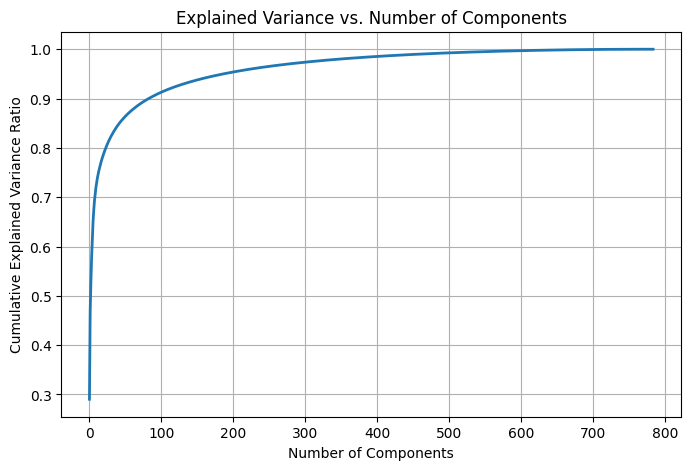

In [38]:
 #Your code
# Compute PCA for all 784 components (the maximum)
_, _, _, eigenvals_full = pca_from_scratch(X_train, 784)
explained_variance_ratio = eigenvals_full / np.sum(eigenvals_full)
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 5))
plt.plot(cumulative_explained_variance, linewidth=2)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

 #Your code

You can achieve an accuracy higher than 80% with a simple neural network when the number of features is 784. Based on the previous plot, how many features do you think are needed to reach this accuracy?

Somewhere around 50–200 components might be enough to get close to the performance you get with all 784 features, but the exact number can vary depending on your classifier and problem specifics

# Now we want to use Scikitlearn package for PCA algorithm.

## Define a function to reduce the number of dimension using Scikitlearn built-in functions.

In [39]:
#Your code
def sklearn_pca(X, n_components):
    pca = SklearnPCA(n_components=n_components)
    X_reduced = pca.fit_transform(X)
    return X_reduced, pca  # pca will store the projection info and mean
#Your code

## Define a neural network model to perform a classification task on the Fashion-MNIST dataset.

In [40]:
#Your code
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_classes=10):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

def train_and_evaluate_nn(X_train, y_train, X_test, y_test, input_dim, epochs=5, batch_size=64):
    """
    X_train, y_train, X_test, y_test are NumPy arrays.
    input_dim: number of features for the first layer
    """
    # Convert to torch tensors
    X_train_torch = torch.from_numpy(X_train).float()
    y_train_torch = torch.from_numpy(y_train).long()
    X_test_torch  = torch.from_numpy(X_test).float()
    y_test_torch  = torch.from_numpy(y_test).long()

    # Create data loaders
    train_dataset = torch.utils.data.TensorDataset(X_train_torch, y_train_torch)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Define model, loss, optimizer
    model = SimpleMLP(input_dim=input_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(epochs):
        model.train()
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_torch)
        preds = outputs.argmax(dim=1)
        accuracy = (preds == y_test_torch).float().mean().item()

    return accuracy
#Your code

## Perform a classification task and plot the accuracy as a function of the number of features for the following values: 3, 5, 8, 20, 50, 100, 200, 400, and 784.

Number of features: 3, Accuracy: 0.4738
Number of features: 5, Accuracy: 0.6143
Number of features: 8, Accuracy: 0.7215
Number of features: 20, Accuracy: 0.8055
Number of features: 50, Accuracy: 0.8339
Number of features: 100, Accuracy: 0.8421
Number of features: 200, Accuracy: 0.8538
Number of features: 400, Accuracy: 0.8495
Number of features: 784, Accuracy: 0.8532


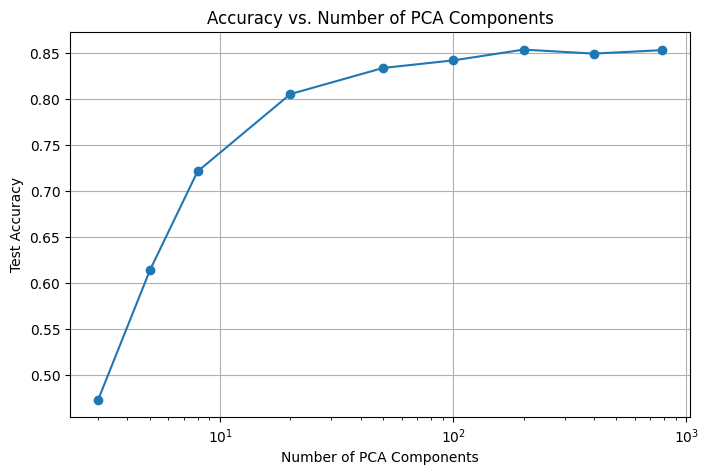

In [41]:
#Your code
dimensions = [3, 5, 8, 20, 50, 100, 200, 400, 784]
accuracies = []

for d in dimensions:
    # 1. Fit PCA on the training set
    X_train_reduced, pca_model = sklearn_pca(X_train, d)
    # 2. Transform the test set
    X_test_reduced = pca_model.transform(X_test)

    # 3. Train and evaluate
    acc = train_and_evaluate_nn(X_train_reduced, y_train,
                                X_test_reduced, y_test,
                                input_dim=d, epochs=5)
    accuracies.append(acc)
    print(f"Number of features: {d}, Accuracy: {acc:.4f}")

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(dimensions, accuracies, marker='o')
plt.xscale('log')  # Optional: log scale for clarity
plt.xlabel('Number of PCA Components')
plt.ylabel('Test Accuracy')
plt.title('Accuracy vs. Number of PCA Components')
plt.grid(True)
plt.show()
  #Your code

### Now, what is the minimum number of features needed to achieve accuracy higher than 80 percent?

somewhere around 50–100 components is enough to exceed 80% accuracy with a simple MLP and a small number of training epochs.

### Could you predict this number according to the explained vaiance plot? why?

The explained variance plot gives a good heuristic. If you see that k components capture, say, 90% of the variance, you might guess that those k components suffice for classification.
However, the directions of high variance are not always the most important for a specific classification task; sometimes lower-variance directions can also be discriminative. Thus, while the cumulative variance plot is a helpful guide, it’s not guaranteed to match exactly the number of components needed to exceed 80% classification accuracy.
In short, the explained variance plot is often correlated with classification performance, but it is not a perfect predictor. You typically still need to experiment with different dimensionalities to see where your model’s accuracy saturates.

